<a href="https://colab.research.google.com/github/UsernameLucky/Machine_Learning-projects/blob/main/Training_a_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ld0dVTR5W1

In [ ]:
#!pip install torch torchvision
#!pip install opencv-contrib-python
#!pip install scikit-learn

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

args = {
    "model": "/content/drive/myDrive/model.pth",
    "plot": "/content/drive/MyDrive/loss_accuracy_plot.png"
}

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [ ]:
pwd

'/content'

# Training a Convolutional Neural Network

When training a Convolutional Neural Network (CNN), a dataset offers a diverse range of inputs and labels essential for the network to learn effectively. This diversity helps the model generalize better when it encounters new, unseen data.

CNNs are a type of deep learning algorithm that can analyze and extract features from images, making them highly effective for image classification and object detection tasks.

In [ ]:
# Importing necessary packages for building a neural network
from torch.nn import Module  # Base class for all neural network modules
from torch.nn import Conv2d  # 2D convolutional layer
from torch.nn import Linear  # Fully connected layer
from torch.nn import MaxPool2d  # 2D max pooling layer
from torch.nn import ReLU  # Rectified linear unit activation function
from torch.nn import LogSoftmax  # Logarithm of the softmax function
from torch import flatten  # Flattens a tensor into 1D


In [ ]:
import matplotlib
matplotlib.use("Agg")  # set the matplotlib backend so figures can be saved in the background

from sklearn.metrics import classification_report  # import classification_report function
from torch.utils.data import random_split  # import random_split function
from torch.utils.data import DataLoader  # import DataLoader class
from torchvision.transforms import ToTensor  # import ToTensor class for transforming data to PyTorch tensors
from torchvision.datasets import KMNIST  # import KMNIST dataset
from torch.optim import Adam  # import Adam optimizer
from torch import nn  # import neural network module from PyTorch
import matplotlib.pyplot as plt  # import matplotlib for plotting
import numpy as np  # import NumPy for numerical computations
import argparse  # import argparse for parsing command line arguments
import torch  # import PyTorch
import time  # import time module for timing operations


## Set hyperparameters

We set parameters to define the training hyperparameters, split the dataset into training and validation sets, and determine the device (CPU or GPU) that will be used for training the model. `INIT_LR` specifies the initial learning rate for the optimizer, `BATCH_SIZE` determines the number of samples in each batch during training, and `EPOCHS` sets the number of times the entire dataset will be passed through the model during training. `TRAIN_SPLIT` and `VAL_SPLIT` define the ratio of the dataset that will be used for training and validation, respectively. Finally, `device` is set to use the GPU (if available) for training, falling back to the CPU otherwise.

In [ ]:
# define training hyperparameters
INIT_LR = 1e-3
BATCH_SIZE = 64
EPOCHS = 10
# define the train and val splits
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and Prepare data

In [ ]:
import time  # import the time module for timing operations
import numpy as np  # import NumPy for numerical computations
import pandas as pd  # import pandas for data manipulation and analysis
import matplotlib.pyplot as plt  # import matplotlib for plotting
from sklearn.metrics import classification_report  # import classification_report function from scikit-learn
import torch  # import PyTorch for deep learning
import torchvision  # import torchvision for computer vision tasks using PyTorch


We loads the KMNIST dataset using the `torchvision.datasets.KMNIST` class. The dataset is split into training and test sets, and each sample is transformed into a PyTorch tensor using `torchvision.transforms.ToTensor()`. The training dataset is further split into training and validation sets using `torch.utils.data.random_split`, based on the `TRAIN_SPLIT` and `VAL_SPLIT` ratios. The random split is generated with a specific seed (`42` in this case) to ensure reproducibility. This process prepares the data for training and evaluation of a machine learning model.

The Kuzushiji-MNIST (KMNIST) dataset is a collection of 70,000 28x28 grayscale images of handwritten Japanese Hiragana characters. It is derived from the original MNIST dataset but focuses on a more challenging and culturally significant task of recognizing characters from the Japanese syllabus. The dataset is split into 60,000 training images and 10,000 test images, with each image belonging to one of 10 classes representing different Hiragana characters.

In [ ]:
# load the KMNIST dataset
print("[INFO] loading the KMNIST dataset...")
trainData = torchvision.datasets.KMNIST(
                root="data",
                train=True,
                download=True,
                transform=torchvision.transforms.ToTensor()
            )
testData = torchvision.datasets.KMNIST(
                root="data",
                train=False,
                download=True,
                transform=torchvision.transforms.ToTensor())

# calculate the train/validation split
print("[INFO] generating the train/validation split...")
numTrainSamples = int(len(trainData) * TRAIN_SPLIT)
numValSamples = int(len(trainData) * VAL_SPLIT)
(trainData, valData) = torch.utils.data.random_split(
                            trainData, [numTrainSamples, numValSamples],
                            generator=torch.Generator().manual_seed(42)
                        )

[INFO] loading the KMNIST dataset...


100%|██████████| 18165135/18165135 [00:12<00:00, 1490075.39it/s]


Extracting data/KMNIST/raw/train-images-idx3-ubyte.gz to data/KMNIST/raw



100%|██████████| 29497/29497 [00:00<00:00, 201788.22it/s]


Extracting data/KMNIST/raw/train-labels-idx1-ubyte.gz to data/KMNIST/raw



100%|██████████| 3041136/3041136 [00:02<00:00, 1370266.48it/s]


Extracting data/KMNIST/raw/t10k-images-idx3-ubyte.gz to data/KMNIST/raw



100%|██████████| 5120/5120 [00:00<00:00, 16430632.35it/s]


Extracting data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to data/KMNIST/raw

[INFO] generating the train/validation split...


In [ ]:
# initialize the train, validation, and test data loaders
trainDataLoader = torch.utils.data.DataLoader(trainData, shuffle=True, batch_size=BATCH_SIZE)
valDataLoader = torch.utils.data.DataLoader(valData, batch_size=BATCH_SIZE)
testDataLoader = torch.utils.data.DataLoader(testData, batch_size=BATCH_SIZE)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

# The model

We define two functions:

init__ function which initializes the layers of the LeNet-5 architecture and then creates two sets of convolutional layers followed by ReLU activation functions and max pooling layers.

We then define a fully connected layer with ReLU activation for feature extraction and LogSoftmax activation for classification.

The forward function defines the forward pass of the network. It passes the input through the first set of convolutional, activation, and pooling layers and the second one.It flattens the output and passes it through the fully connected layers and finally returns the output predictions after applying LogSoftmax activation.

In [ ]:
class LeNet(torch.nn.Module):

    def __init__(self, numChannels, classes):
        # call the parent constructor
        super(LeNet, self).__init__()

        # initialize first set of CONV => RELU => POOL layers
        self.conv1 = torch.nn.Conv2d(
                        in_channels=numChannels,
                        out_channels=20,
                        kernel_size=(5, 5)
                     )
        self.relu1 = torch.nn.ReLU()
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        # initialize second set of CONV => RELU => POOL layers
        self.conv2 = torch.nn.Conv2d(
                        in_channels=20,
                        out_channels=50,
                        kernel_size=(5, 5)
                     )
        self.relu2 = torch.nn.ReLU()
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        # initialize first (and only) set of FC => RELU layers
        self.fc1 = torch.nn.Linear(in_features=800, out_features=500)
        self.relu3 = torch.nn.ReLU()

        # initialize our softmax classifier
        self.fc2 = torch.nn.Linear(in_features=500, out_features=classes)
        self.logSoftmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Pass the input through our first set of CONV => RELU =>
        # POOL layers
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        # Pass the output from the previous layer through the second
        # set of CONV => RELU => POOL layers
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        # Flatten the output from the previous layer and pass it
        # through our only set of FC => RELU layers
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)

        # Pass the output to our softmax classifier to get our output
        # predictions
        x = self.fc2(x)
        output = self.logSoftmax(x)

        # return the output predictions
        return output

The following code initializes the LeNet model for training on the KMNIST dataset. It sets up the model architecture, optimizer, loss function, and data structures for storing training history.

In [ ]:
# initialize the LeNet model
print("[INFO] initializing the LeNet model...")
model = LeNet(
	numChannels=1,
	classes=len(trainData.dataset.classes)).to(device)
# initialize our optimizer and loss function
opt = Adam(model.parameters(), lr=INIT_LR)
lossFn = nn.NLLLoss()
# initialize a dictionary to store training history
H = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}
# measure how long training is going to take
print("[INFO] training the network...")
startTime = time.time()

[INFO] initializing the LeNet model...
[INFO] training the network...


#  Model Fitting

The following code trains the LeNet model on the KMNIST dataset for a specified number of epochs (`EPOCHS`). It loops over each epoch, setting the model in training mode and iterating over the training dataset (`trainDataLoader`). For each batch, it sends the input data to the device (CPU or GPU), performs a forward pass through the model, calculates the loss, computes gradients, and updates the weights. It also calculates the total training loss and the number of correct predictions for the training set.

After each epoch, the model is switched to evaluation mode, and the validation dataset (`valDataLoader`) is iterated over to calculate the validation loss and the number of correct predictions. The average training and validation losses are computed, along with the training and validation accuracies. The training history (`H`) is updated with these metrics, and a summary of the epoch's training and validation performance is printed.

The total time taken for training is calculated and printed.

In [ ]:
# measure how long training is going to take
print("[INFO] training the network...")
startTime = time.time()

# Loop over our epochs
for e in range(0, EPOCHS):
    # Set the model in training mode
    model.train()

    # Initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0

    # Initialize the number of correct predictions in the training
    # and validation step
    trainCorrect = 0
    valCorrect = 0

    # Loop over the training set
    for (x, y) in trainDataLoader:
        # Send the input to the device
        (x, y) = (x.to(device), y.to(device))

        # Perform a forward pass and calculate the training loss
        pred = model(x)
        loss = lossFn(pred, y)

        # Zero out the gradients, perform the backpropagation step,
        # and update the weights
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Add the loss to the total training loss so far and
        # calculate the number of correct predictions
        totalTrainLoss += loss
        trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Switch off autograd for evaluation
    with torch.no_grad():
        # Set the model in evaluation mode
        model.eval()

        # Loop over the validation set
        for (x, y) in valDataLoader:
            # Send the input to the device
            (x, y) = (x.to(device), y.to(device))

            # Make the predictions and calculate the validation loss
            pred = model(x)
            totalValLoss += lossFn(pred, y)

            # Calculate the number of correct predictions
            valCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps

    # Calculate the training and validation accuracy
    trainCorrect = trainCorrect / len(trainDataLoader.dataset)
    valCorrect = valCorrect / len(valDataLoader.dataset)

    # Update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["train_acc"].append(trainCorrect)
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())
    H["val_acc"].append(valCorrect)

    # Print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainCorrect))
    print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(avgValLoss, valCorrect))

# Finish measuring how long training took
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...
[INFO] EPOCH: 1/10
Train loss: 0.350819, Train accuracy: 0.8907
Val loss: 0.140844, Val accuracy: 0.9581

[INFO] EPOCH: 2/10
Train loss: 0.101437, Train accuracy: 0.9692
Val loss: 0.110056, Val accuracy: 0.9677

[INFO] EPOCH: 3/10
Train loss: 0.058615, Train accuracy: 0.9817
Val loss: 0.079302, Val accuracy: 0.9768

[INFO] EPOCH: 4/10
Train loss: 0.039407, Train accuracy: 0.9876
Val loss: 0.073150, Val accuracy: 0.9790

[INFO] EPOCH: 5/10
Train loss: 0.025614, Train accuracy: 0.9917
Val loss: 0.080415, Val accuracy: 0.9781

[INFO] EPOCH: 6/10
Train loss: 0.017958, Train accuracy: 0.9941
Val loss: 0.078820, Val accuracy: 0.9799

[INFO] EPOCH: 7/10
Train loss: 0.014729, Train accuracy: 0.9952
Val loss: 0.095806, Val accuracy: 0.9779

[INFO] EPOCH: 8/10
Train loss: 0.012490, Train accuracy: 0.9962
Val loss: 0.091742, Val accuracy: 0.9793

[INFO] EPOCH: 9/10
Train loss: 0.010241, Train accuracy: 0.9967
Val loss: 0.096841, Val accuracy: 0.9781

[INFO] EPOCH: 1

This output shows the training progress of the LeNet model over 10 epochs on the KMNIST dataset.
- "Train loss" and "Val loss" indicate the average loss over the entire training and validation datasets for the respective epoch.
- "Train accuracy" and "Val accuracy" show the proportion of correct predictions over the entire training and validation datasets for the respective epoch.

The values for each metric generally improve with each epoch, indicating that the model is learning and improving its performance.The total time taken to train the model  is 540.21 seconds.

# Evaluation

This code evaluates the trained LeNet model on the test set and prints a classification report. It calculates the total training time and then evaluates the model on the test set by making predictions and comparing them with the actual labels to generate a classification report, which includes metrics like precision, recall, and F1-score for each class in the dataset.

In [ ]:
# finish measuring how long training took
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))
# we can now evaluate the network on the test set
print("[INFO] evaluating network...")
# turn off autograd for testing evaluation
with torch.no_grad():
	# set the model in evaluation mode
	model.eval()

	# initialize a list to store our predictions
	preds = []
	# loop over the test set
	for (x, y) in testDataLoader:
		# send the input to the device
		x = x.to(device)
		# make the predictions and add them to the list
		pred = model(x)
		preds.extend(pred.argmax(axis=1).cpu().numpy())
# generate a classification report
print(classification_report(testData.targets.cpu().numpy(),
	np.array(preds), target_names=testData.classes))

[INFO] total time taken to train the model: 936.49s
[INFO] evaluating network...
              precision    recall  f1-score   support

           o       0.95      0.97      0.96      1000
          ki       0.95      0.93      0.94      1000
          su       0.91      0.90      0.90      1000
         tsu       0.93      0.98      0.96      1000
          na       0.91      0.94      0.93      1000
          ha       0.98      0.93      0.95      1000
          ma       0.91      0.97      0.94      1000
          ya       0.99      0.95      0.97      1000
          re       0.97      0.96      0.97      1000
          wo       0.99      0.94      0.97      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



This output shows the total time taken to train the model (936.49 seconds) and the results of evaluating the model on the test set. The classification report displays metrics such as precision, recall, and F1-score for each class in the dataset, as well as overall accuracy. The model achieved an overall accuracy of 95% on the test set, with individual class performance varying between 91% and 99% precision.

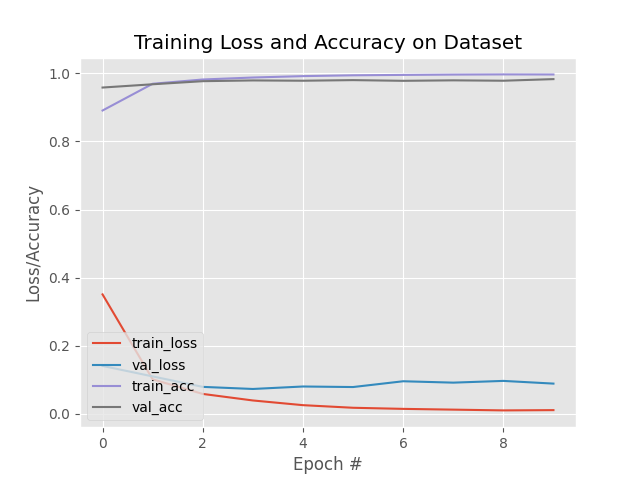

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("Figure")
#torch.save(model, args["model"])
#plt.savefig(args["plot"])







from IPython.display import Image, display

image_path = "/content/Figure.png"
display(Image(filename=image_path))




The diagram shows the performance of a Convolutional Neural Network (CNN), over multiple training cycles (epochs).
It shows:

 Training Loss (red line):This line indicates how well the model performs on individual training examples. Lower values represent better performance during training. As the model learns from the data, this line trends downwards.

 Training Accuracy (purple line): This line shows the proportion of training examples the model classified correctly. Higher values indicate better performance. As training progresses, this line trends upwards.


 Validation Loss (blue line): This line measures the model's performance on a validation set data not used for training. This helps assess how well the model generalizes to unseen data and avoids overfitting.

 Validation Accuracy (green line): This line shows the proportion of examples in the validation set the model classified correctly. An increasing trend indicates the model is learning effectively and generalizing well to unseen data.




In [ ]:
# set the numpy seed for better reproducibility
import numpy as np
np.random.seed(42)

# import the necessary packages
from torch.utils.data import DataLoader  # import DataLoader class for batch loading data
from torch.utils.data import Subset  # import Subset class for creating a subset of a dataset
from torchvision.transforms import ToTensor  # import ToTensor class for transforming data to PyTorch tensors
from torchvision.datasets import KMNIST  # import KMNIST dataset
import argparse  # import argparse for parsing command line arguments
import imutils  # import imutils for image processing and manipulation
import torch  # import PyTorch for deep learning
import cv2  # import OpenCV for image processing



The following code sets the device for model training based on GPU availability, loads the KMNIST test dataset, selects 10 random data points for evaluation, initializes a data loader for the test dataset, and loads a pre-trained model for evaluation.

In [ ]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the KMNIST dataset and randomly grab 10 data points
print("[INFO] loading the KMNIST test dataset...")
testData = KMNIST(root="data", train=False, download=True, transform=ToTensor())
idxs = np.random.choice(range(0, len(testData)), size=(10,))
testData = Subset(testData, idxs)

# Initialize the test data loader
testDataLoader = DataLoader(testData, batch_size=1)

# Load the model and set it to evaluation mode
model = torch.load("model.pth").to(device)
model.eval()


[INFO] loading the KMNIST test dataset...


LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (logSoftmax): LogSoftmax(dim=1)
)

In [ ]:
from google.colab.patches import cv2_imshow

The following code disables autograd functionality in PyTorch to prevent unnecessary gradient computations. Within this context, it iterates over the test dataset, making predictions with a pre-trained model. For each image in the test set, it extracts the original image and ground truth label, sends the image to the specified device (CPU or GPU), and makes predictions using the model. It then visualizes the original image, overlays the predicted label on it, and displays the result along with the ground truth label. Finally, it scales and displays the image for inspection and waits for user input to proceed to the next image.

[INFO] ground truth label: re, predicted label: re


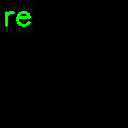

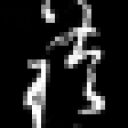

[INFO] ground truth label: re, predicted label: re


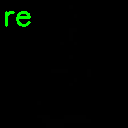

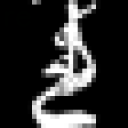

[INFO] ground truth label: o, predicted label: o


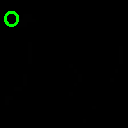

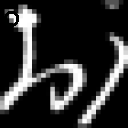

[INFO] ground truth label: na, predicted label: na


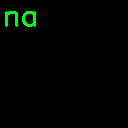

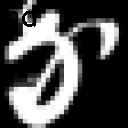

[INFO] ground truth label: ma, predicted label: ma


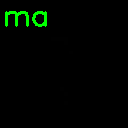

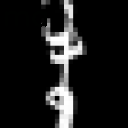

[INFO] ground truth label: ha, predicted label: su


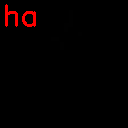

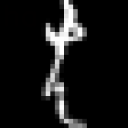

[INFO] ground truth label: ki, predicted label: ki


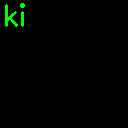

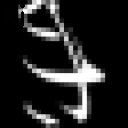

[INFO] ground truth label: ma, predicted label: ma


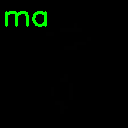

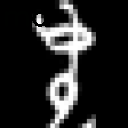

[INFO] ground truth label: ma, predicted label: ma


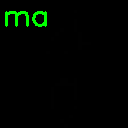

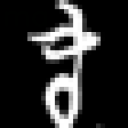

[INFO] ground truth label: ki, predicted label: ki


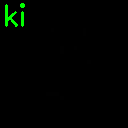

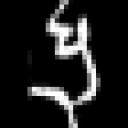

In [ ]:
# switch off autograd
with torch.no_grad():
    # loop over the test set
    for (image, label) in testDataLoader:
        # grab the original image and ground truth label
        origImage = image.numpy().squeeze(axis=(0, 1))
        gtLabel = testData.dataset.classes[label.numpy()[0]]
        # send the input to the device and make predictions on it
        image = image.to(device)
        pred = model(image)
        # find the class label index with the largest corresponding
        # probability
        idx = pred.argmax(axis=1).cpu().numpy()[0]
        predLabel = testData.dataset.classes[idx]

        # convert the image from grayscale to RGB (so we can draw on
        # it) and resize it (so we can more easily see it on our
        # screen)
        origImage = np.dstack([origImage] * 3)
        origImage = imutils.resize(origImage, width=128)
        # draw the predicted class label on it
        color = (0, 255, 0) if gtLabel == predLabel else (0, 0, 255)
        cv2.putText(origImage, gtLabel, (2, 25),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.95, color, 2)

        # Display the result in the terminal and show the input image
        print("[INFO] ground truth label: {}, predicted label: {}".format( gtLabel, predLabel))
        #scalling the image
        scaledImage=(origImage*255).astype(np.uint8)
        # Use cv2_imshow instead of cv2.imshow in Colab

        cv2_imshow(origImage)
        cv2_imshow(scaledImage)
        cv2.waitKey(0)



The above output shows that we can successfully identify the characters.
